In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [19]:
#Load the data
df=pd.read_csv('C:\\TensorFlow\\AAPL.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (755, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800


In [20]:
#Check the datatype
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [21]:
#check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [22]:
# Convert Date to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [23]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,107.9000,108.3000,107.5100,107.7000,102.6637,26880400
1,2016-09-07,107.8300,108.7600,107.0700,108.3600,103.2928,42364300
2,2016-09-08,107.2500,107.2700,105.2400,105.5200,100.5856,53002000
3,2016-09-09,104.6400,105.7200,103.1300,103.1300,98.3074,46557000
4,2016-09-12,102.6500,105.7200,102.5300,105.4400,100.5094,45292800


In [24]:
#Keep only Adj Close and Volume
df = df.iloc[:,[5,6]].values

[]

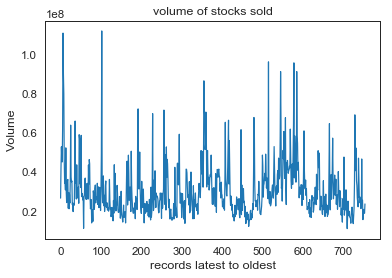

In [26]:
plt.plot(df[:,1])
plt.title("volume of stocks sold")
plt.xlabel("records latest to oldest")
plt.ylabel("Volume")
plt.plot()

[]

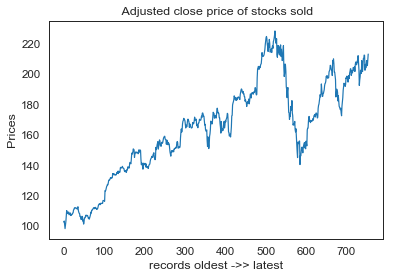

In [27]:
#plot for closing price
plt.plot(df[:,0])
plt.title(" Adjusted close price of stocks sold")
plt.xlabel("records oldest ->> latest")
plt.ylabel("Prices")
plt.plot()

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

1. Create the dataset, ensure all data is float.

2. Normalize the features.

3. Split into training and test sets.

4. Convert an array of values into a dataset matrix.

5. Reshape into X=t and Y=t+1.

6. Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [58]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(df[:,:])


This is a time series problem. If we need to predict the Apple stock prices correctly then we need to consider the volume of the stocks traded from the previous days as well as the adjusted closing stock prices from previous days.


We will be creating the data that will go back to 50 business days in past for the prediction.

Also, we will take 30 % of the latest data as our test dataset.

For RNN LSTM to predict the data we need to convert the input data.

Input data is in the form: [Volume of stocks traded, Adj Close stock price] and we need to create a time series data.
The time series data for today should contain the [Volume of stocks traded, Adj Close stock price] for past 50 days and the target variable will be Apple’s adj close price today and so on.

In [59]:
trainSize =int(len(dataset)*.70)
testSize = len(dataset) - trainSize
train,test = dataset[0:trainSize,:],dataset[trainSize:len(dataset),:]
print(train.shape,test.shape)
def seriesToSupervised(data,lookback=1):
    X,y = list(),list()
    for i in range(len(data)-lookback-1):
        xTemp = data[i:(i+lookback),:]
        yTemp = data[i+lookback,0]
        X.append(xTemp)
        y.append(yTemp)
    return np.array(X),np.array(y)
lookback= 50
x_train,y_train = seriesToSupervised(train,lookback)
x_test,y_test= seriesToSupervised(test,lookback)
print( x_train.shape,x_test.shape)

(528, 2) (227, 2)
(477, 50, 2) (176, 50, 2)


In [60]:
y_train.shape

(477,)

In [63]:
# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(477,50,2)
x_test = x_test.reshape(176,50,2)


In [70]:
#Model declaration
#Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Volume.
#The input shape will be 1 time step with 30 features.
model = Sequential()

model.add(LSTM(30, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True)) 

model.add(LSTM(30))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

trModel = model.fit(x_train, y_train, epochs=20, batch_size=30, validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 477 samples, validate on 176 samples
Epoch 1/20
477/477 [==============================] - 4s 8ms/step - loss: 0.0354 - val_loss: 0.0732
Epoch 2/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0528 - val_loss: 0.0409
Epoch 3/20
477/477 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 4/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 5/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 6/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 7/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 8/20
477/477 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 9/20
477/477 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/20
477/477 [==============================] -

In [71]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict[:2,0])
print(y_train[:2])


[0.0920275  0.08802157]
[0.03316106 0.05435198]


In [72]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_predict[:,0])))

Train Mean Absolute Error: 0.026465638333191484
Train Root Mean Squared Error: 0.03531811408226283
Test Mean Absolute Error: 0.03913858245556894
Test Root Mean Squared Error: 0.05240864476204701


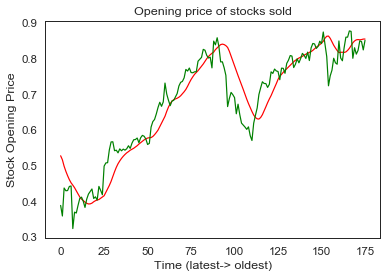

In [74]:
#lloks like our network has captured the overall trend, rest can be finetuned 
plt.plot(test_predict, color= 'red')
plt.plot(y_test, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

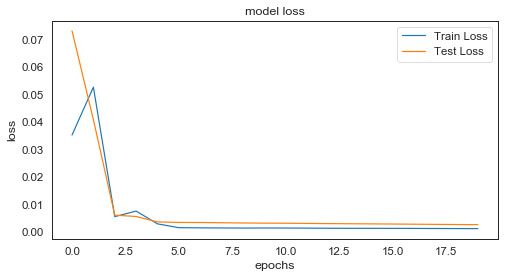

In [75]:
#Visualizing loss
plt.figure(figsize=(8,4))
plt.plot(trModel.history['loss'], label='Train Loss')
plt.plot(trModel.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();